In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

### Constants

In [10]:
# Mass
m = 0.030

# Principle moments of inertia
J_y = 1.60e-05
J_x = 1.60e-05
J_z = 1.60e-05
J_in1 = sym.diag(J_x, J_y, J_z)


# Acceleration of gravity
g = 9.81

# # Pendulum parameters
l_pen = 620e-3 # maybe m
m_pen = 0.006

In [18]:
def Rotate(alpha, beta, gamma):
    Rz = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha), 0],
                 [sym.sin(alpha), sym.cos(alpha), 0],
                 [0, 0, 1]])

    Ry = sym.Matrix([[sym.cos(beta), 0, sym.sin(beta)],
                 [0, 1, 0],
                 [-sym.sin(beta), 0, sym.cos(beta)]])

    Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(gamma), -sym.sin(gamma)],
                 [0, sym.sin(gamma), sym.cos(gamma)]])

    R_VtoO = Rz * Ry * Rx

    return R_VtoO

def N_func(alpha, beta, gamma):
    Ninv = sym.Matrix([[sym.cos(beta)*sym.cos(gamma), -sym.sin(gamma), 0],
                       [sym.cos(beta)*sym.sin(gamma), sym.cos(gamma), 0],
                       [-sym.sin(beta), 0, 1]])

    # N = sym.simplify(Ninv.inv())
    N = Ninv.inv()
    return N

### State Derivative

Calculates the derivative of the state.

In [19]:
def propogate_state(state, inputs):
    # state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
    # state: [o_x, vx, o_y, vy, o_z, vz, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
    # state_dot: [o_x_dot, vx_dot, o_y_dot, vy_dot, o_z_dot, vz_dot, alpha_dot, beta_dot, gamma_dot, wx_dot, wy_dot, wz_dot, r_dot, s_dot, r_ddot, s_ddot]

    # inputs: [tau_x, tau_y, tau_z, f_z]
    Rotation_matrix = Rotate(state[6], state[7], state[8])
    N = N_func(state[6], state[7], state[8])
    # second_derivatives = Rotation_matrix * sym.Matrix([0, 0, inputs[3]])/m + sym.Matrix([0, 0, -g])
    angle_derivatives = N * sym.Matrix([state[9], state[10], state[11]]) # [gamma_dot, beta_dot, alpha_dot]
    f_in1 = Rotation_matrix.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, inputs[3]])
    tau_in1 = sym.Matrix([inputs[0], inputs[1], inputs[2]])
    w_01in1 = sym.Matrix([state[9], state[10], state[11]])
    w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
    zeta = np.sqrt(l_pen**2 - state[12]**2 - state[13]**2)
    state_dot = np.zeros(16)
    
    # NEW CHANGES
    v_01in1 = sym.Matrix([state[1], state[3], state[5]])
    o_dot = Rotation_matrix @ v_01in1 # o_dot matrix in terms of vx,vy,vz
    v_dot = (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1))
    o_ddot = Rotation_matrix @ v_dot

    # vx, vy, vz (state) --> oxdot, oydot, ozdot (calculate)
    # oxddot, oyddot, ozddot (second derivatives) --> vxdot, vydot, vzdot (calcul)
    state_dot[0] = o_dot[0]
    state_dot[1] = v_dot[0]
    state_dot[2] = o_dot[1]
    state_dot[3] = v_dot[1]
    state_dot[4] = o_dot[2]
    state_dot[5] = v_dot[2]
    state_dot[6] = angle_derivatives[2]
    state_dot[7] = angle_derivatives[1]
    state_dot[8] = angle_derivatives[0]
    state_dot[9] = w_derivatives[0]
    state_dot[10] = w_derivatives[1]
    state_dot[11] = w_derivatives[2]
    state_dot[12] = state[14]
    state_dot[13] = state[15]
    r = state[12]
    rd = state[14]
    s = state[13]
    sd = state[15]
    xdd = o_ddot[0] # UPDATED
    ydd = o_ddot[1] # UPDATED
    state_dot[15] = (g*l_pen**2*s*zeta - g*r**2*s*zeta - g*s**3*zeta - l_pen**4*ydd + l_pen**2*xdd*r*s + l_pen**2*ydd*r**2 + 2*l_pen**2*ydd*s**2 + l_pen**2*ydd*s*zeta - l_pen**2*rd**2*s - l_pen**2*s*sd**2 - xdd*r**3*s - xdd*r*s**3 - ydd*r**2*s**2 - ydd*r**2*s*zeta - ydd*s**4 - ydd*s**3*zeta + r**2*s*sd**2 - 2*r*rd*s**2*sd + rd**2*s**3)/((r**2 - l_pen**2)*(s**2 - l_pen**2))
    state_dot[14] = (g*l_pen**2*r*zeta - g*s**2*r*zeta - g*r**3*zeta - l_pen**4*xdd + l_pen**2*ydd*r*s + l_pen**2*xdd*s**2 + 2*l_pen**2*xdd*r**2 + l_pen**2*ydd*r*zeta - l_pen**2*rd**2*r - l_pen**2*r*sd**2 - ydd*r**3*s - ydd*r*s**3 - xdd*r**2*s**2 - ydd*s**2*r*zeta - xdd*r**4 - ydd*r**3*zeta + s**2*r*rd**2 - 2*s*sd*r**2*rd + sd**2*r**3)/((r**2 - l_pen**2)*(s**2 - l_pen**2))

    return state_dot

### RK4 propogator

To get the next state

In [20]:
def rk4(state, inputs, delta_t):
    y1 = propogate_state(state, inputs)
    y2 = propogate_state(state + 1/2*delta_t*y1, inputs)
    y3 = propogate_state(state + 1/2*delta_t*y2, inputs)
    y4 = propogate_state(state + delta_t*y3, inputs)

    return state + 1/6 * delta_t *(y1 + 2*y2 + 2*y3 + y4)


### Controller

To calculate the inputs based on the current state. The K values are from the `planar_problem_state_space.ipynb` notebook.

In [21]:
def controller(state, state_des):
    K = np.array([[ 2.18419435e-16,  8.74671160e-17,  1.00000000e-03,
         1.92508965e-03,  1.20561973e-18,  1.61593807e-20,
         1.07795970e-18, -6.38280912e-16,  1.59841804e-02,
         1.22552163e-03, -5.11312374e-18, -3.09730372e-17,
         2.09229000e-15,  5.85139281e-02,  4.81448986e-16,
         1.32460826e-02],
       [-1.00000000e-03, -1.92537771e-03,  5.81745492e-16,
         9.57183086e-16, -1.55007872e-17,  7.66072114e-19,
         1.04613054e-19,  1.60148062e-02,  1.88059521e-15,
        -5.01725267e-18,  1.22982674e-03, -1.85181738e-17,
        -5.85860608e-02,  1.37286717e-14, -1.32623234e-02,
         3.06164624e-15],
       [ 2.27613203e-16,  3.64073935e-16, -6.49175411e-17,
        -1.71070511e-16,  3.05544168e-18,  2.09861760e-19,
         1.00000000e-03, -1.24313289e-15, -6.75150463e-16,
        -2.37208138e-17, -1.44532088e-17,  1.02029408e-03,
         6.42265463e-15, -3.32065048e-15,  1.46285551e-15,
        -7.42558338e-16],
       [ 1.28926626e-14,  6.49266205e-15,  2.16918558e-16,
         1.81032956e-16,  3.16227766e-01,  3.57530479e-01,
         2.68186831e-17,  4.55083197e-15,  2.57757833e-16,
         5.76596083e-19,  2.78571678e-17,  9.77765016e-18,
         3.65509034e-14,  1.45029099e-15,  8.23027598e-15,
         2.61016589e-16]])
    u = -K @ (state - state_des)
    u[3] += (m)*g # Adding the equilibrium f_z value
    return u

Run the sim

In [22]:
def sim(times,inputs_data, state_data, state_des, delta_t):
    for i, time in enumerate(times):

        if i == 0:
            continue

        else:
            inputs_data[i-1] = controller(state_data[i-1], state_des)
            state_data[i] = rk4(state_data[i-1], inputs_data[i-1], delta_t)

In [26]:
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

# Set up sim
delta_t = 0.01
total_t = 10
times = np.arange(0, total_t + delta_t/2, delta_t)
inputs_data = np.zeros((len(times), 4))
state_data = np.zeros((len(times), 16))

# Desired States
state_des = np.array([0., 0., 0.0, 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# Initial condition
state_data[0] = np.array([0., 0., 0.0, 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.01, 0.01, 0.0, 0.0])

# Run sim
sim(times, inputs_data, state_data, state_des, delta_t)

In [27]:
# Convert inputs data to motor commands
k_F = 2.04e-06
k_M = 6.33e-09
l = .0325 

P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Pinv = linalg.inv(P)

motor_commands = np.zeros((len(times), 4))
for i in range(len(times)):
    motor_commands[i] = Pinv @ inputs_data[i]


### Plotting and animation

Text(0.5, 0, 'time (s)')

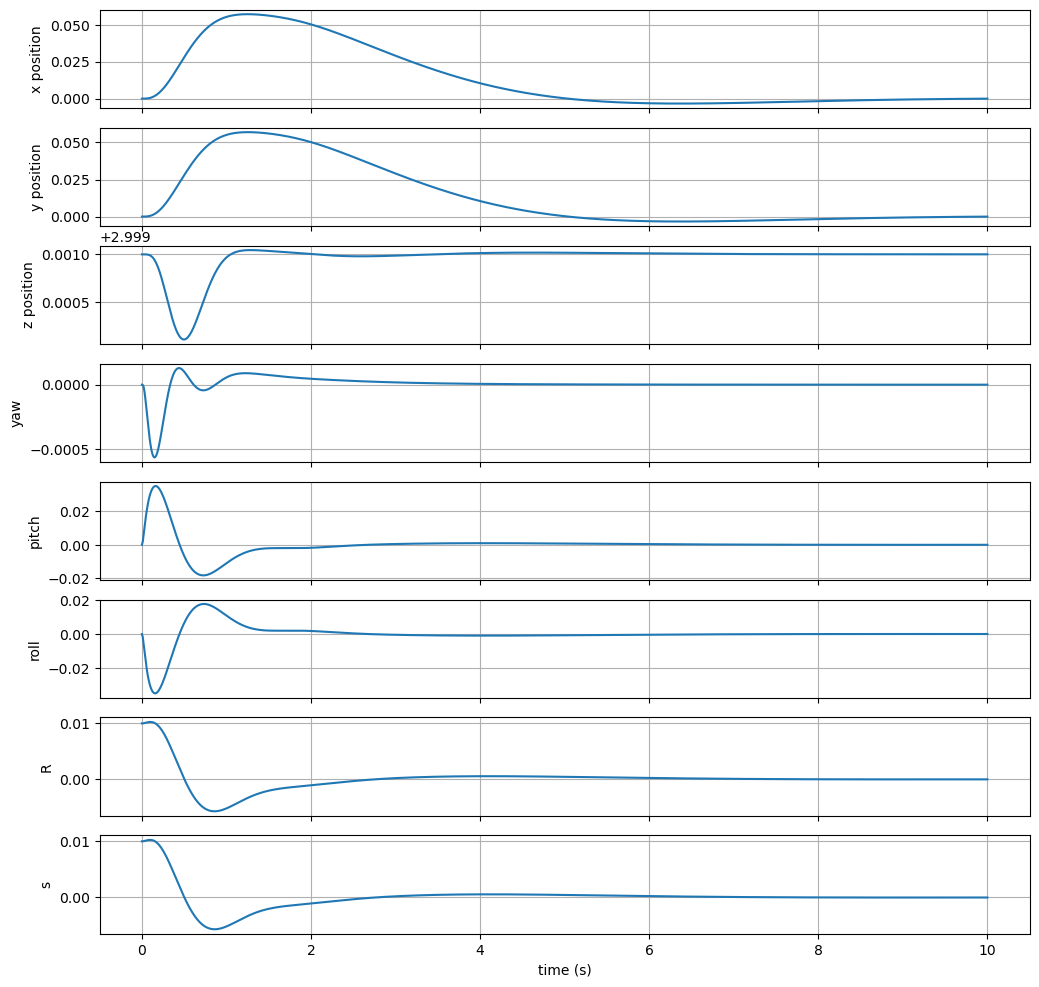

In [28]:
fig, (ax_o_x, ax_o_y, ax_o_z, ax_alpha, ax_beta, ax_gamma, ax_r_offset, ax_s_offset) = plt.subplots(8, 1, figsize=(12, 12), sharex=True)

# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

ax_o_x.plot(times, state_data[:,0])
ax_o_x.set_ylabel('x position')
ax_o_y.plot(times, state_data[:,2])
ax_o_y.set_ylabel('y position')
ax_o_z.plot(times, state_data[:,4])
ax_o_z.set_ylabel('z position')
ax_alpha.plot(times, state_data[:,6])
ax_alpha.set_ylabel('yaw')
ax_beta.plot(times, state_data[:,7])
ax_beta.set_ylabel('pitch')
ax_gamma.plot(times, state_data[:,8])
ax_gamma.set_ylabel('roll')
ax_r_offset.plot(times, state_data[:,12])
ax_r_offset.set_ylabel('R')
ax_s_offset.plot(times, state_data[:,13])
ax_s_offset.set_ylabel('s')
ax_o_x.grid()
ax_o_y.grid()
ax_o_z.grid()
ax_alpha.grid()
ax_beta.grid()
ax_gamma.grid()
ax_r_offset.grid()
ax_s_offset.grid()
ax_s_offset.set_xlabel('time (s)')


Text(0.5, 0, 'Time')

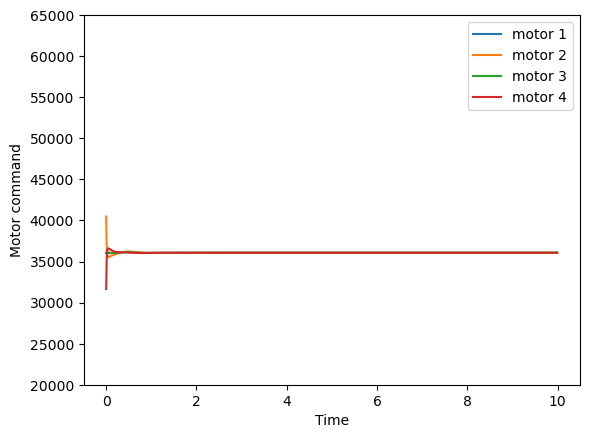

In [31]:
plt.plot(times[:-1], motor_commands[:-1,0], label="motor 1")
plt.plot(times[:-1], motor_commands[:-1,1], label="motor 2")
plt.plot(times[:-1], motor_commands[:-1,2], label="motor 3")
plt.plot(times[:-1], motor_commands[:-1,3], label="motor 4")
plt.legend()
plt.ylim((20000, 65000))
plt.ylabel("Motor command")
plt.xlabel("Time")

In [32]:
# Write State Data and Timestamps to a csv for Animation

import os
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

record = []
for point in range(len(times)):
    cur_point = []
    cur_point.append(str(times[point]))
    cur_point.append(str(state_data[point,0])) #x-pos
    cur_point.append(str(state_data[point, 2])) #y-pos
    cur_point.append(str(state_data[point, 4])) #z-pos
    cur_point.append(str(state_data[point, 6])) #yaw
    cur_point.append(str(state_data[point, 7])) #pitch
    cur_point.append(str(state_data[point, 8])) #roll
    cur_point.append(str(state_data[point, 12])) #r
    cur_point.append(str(state_data[point, 13])) #s
    record.append(cur_point)

output_file = '3d-sim.csv'
with open(output_file, 'w') as f:
    f.write("time,x,y,z,yaw,pitch,roll,r,s\n")
    for point in record:
        f.write(f"{','.join(point)}\n")

### Controller Design


In [11]:
# Added vx,vy,vz as part of state variables
o_x, o_y, o_z, vx, vy, vz, alpha, beta, gamma, wx, wy, wz, ox_dot, oy_dot, oz_dot= sym.symbols(r'o_x o_y o_z vx vy vz \alpha \beta \gamma w_x w_y w_z ox_{dot} oy_{dot} oz_{dot}')
tau_x, tau_y, tau_z, f_z = sym.symbols('tau_x, tau_y, tau_z, f_z')
m, Jx, Jy, Jz = sym.symbols('m J_x J_y J_z')
J_in1 = sym.diag(Jx, Jy, Jz)
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])
w_01in1 = sym.Matrix([wx, wy, wz])
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

# state: [o_x, vx, o_y, vy, o_z, vz, alpha, beta, gamma, wx, wy, wz]
# state_dot: [o_x_dot, vx_dot, o_y_dot, vy_dot, o_z_dot, vz_dot, alpha_dot, beta_dot, gamma_dot, wx_dot, wy_dot, wz_dot]

# inputs: [tau_x, tau_y, tau_z, f_z]
Rotation_matrix = Rotate(alpha, beta, gamma)
N = N_func(alpha, beta, gamma)
# second_derivatives = Rotation_matrix * sym.Matrix([0, 0, f_z])/m + sym.Matrix([0, 0, -g])
angle_derivatives = N * sym.Matrix([wx, wy, wz]) # [gamma_dot, beta_dot, alpha_dot]
w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
f_in1 = Rotation_matrix.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])
f_sym = sym.zeros(12,1)
# # f_sym[0] = ox_dot
# f_sym[1] = second_derivatives[0]
# # f_sym[2] = oy_dot
# f_sym[3] = second_derivatives[1]
# # f_sym[4] = oz_dot
# f_sym[5] = second_derivatives[2]
f_sym[6] = angle_derivatives[2]
f_sym[7] = angle_derivatives[1]
f_sym[8] = angle_derivatives[0]
f_sym[9] = w_derivatives[0]
f_sym[10] = w_derivatives[1]
f_sym[11] = w_derivatives[2]

# NEW CHANGES

v_01in1 = sym.Matrix([vx, vy, vz])
o_dot = Rotation_matrix @ v_01in1 # o_dot matrix in terms of vx,vy,vz
v_dot = (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1))
f_sym[0] = o_dot[0]
f_sym[1] = v_dot[0]
f_sym[2] = o_dot[1]
f_sym[3] = v_dot[1]
f_sym[4] = o_dot[2]
f_sym[5] = v_dot[2]

f_sym

Matrix([
[                                                                                                                                                                     ox_{dot}],
[                                                                                                         f_z*(sin(\alpha)*sin(\gamma) + sin(\beta)*cos(\alpha)*cos(\gamma))/m],
[                                                                                                                                                                     oy_{dot}],
[                                                                                                         f_z*(sin(\alpha)*sin(\beta)*cos(\gamma) - sin(\gamma)*cos(\alpha))/m],
[                                                                                                                                                                     oz_{dot}],
[                                                                                                         

In [12]:
s = [o_x, ox_dot, o_y, oy_dot, o_z, oz_dot, alpha, beta, gamma, wx, wy, wz]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, Jx, Jy, Jz]

In [13]:
f = sym.lambdify(s + i + p, f_sym)
f

<function _lambdifygenerated(o_x, ox_dot, o_y, oy_dot, o_z, oz_dot, Dummy_162, Dummy_161, _Dummy_160, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z, m, J_x, J_y, J_z)>

In [14]:
# Mass
m = 0.044

# Principle moments of inertia
J_x = 1.57e-05
J_y = 1.60e-05
J_z = 2.05e-05

# Acceleration of gravity
g = 9.81

p_eq = [m, J_x, J_y, J_z]

In [15]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
i_eq = [0., 0., 0., g*(m)]

In [17]:
print(f(*s_eq, *i_eq, *p_eq))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [18]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

In [48]:
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
############# JANK SHIT    ##############################
A_mod = np.vstack((np.hstack((A, np.zeros((12, 4)))), np.zeros((4,16))))
A_mod[12,14] = 1.0
A_mod[13,15] = 1.0
A_mod[14,12] = g/l_pen
A_mod[14, 7] = -g
A_mod[15,13] = g/l_pen
A_mod[15, 8] = g

B_mod = np.vstack((B, np.zeros((4,4))))

In [49]:

A_str = np.array2string(A_mod,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  9.81  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -9.81  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  1.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  

In [50]:
B_str = np.array2string(B_mod,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)
B
print(f'B = {B_str}')

B = [[      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00      22.73]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [  63694.27       0.00       0.00       0.00]
     [      0.00   62500.00       0.00       0.00]
     [      0.00       0.00   48780.49       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]]


In [51]:
Q = np.diag([
    1., 
    1., 
    1., 
    1., 
    1., 
    1., 
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.
])

R = np.diag([
    1E6, #tau_x
    1E6,#tau_y
    1E6,
    10,
])

def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K


In [52]:
K = lqr(A_mod, B_mod, Q, R)

K

array([[-5.29778089e-16, -3.60880523e-16,  1.00000000e-03,
         1.97854229e-03,  4.86422286e-17,  7.66640838e-18,
        -4.10433930e-17,  3.16936081e-16,  1.49060113e-02,
         1.21163062e-03,  1.40037562e-18, -3.41410149e-17,
        -2.88537526e-15,  4.71004344e-02, -7.27847972e-16,
         1.18804338e-02],
       [-1.00000000e-03, -1.97883026e-03, -6.27118644e-17,
        -1.10589968e-16, -1.44068131e-16, -1.35962612e-16,
         2.39862484e-16,  1.49329422e-02, -3.62011990e-16,
         1.37411857e-18,  1.21567025e-03,  1.79840404e-17,
        -4.71528871e-02, -1.74979260e-15, -1.18935765e-02,
        -4.68173885e-16],
       [-2.32041728e-16, -4.02207201e-16,  2.63397585e-16,
         1.84098486e-16, -8.91189097e-19, -2.15850277e-19,
         1.00000000e-03,  1.05152028e-15,  2.22428512e-17,
        -2.61470212e-17,  1.40363242e-17,  1.02029408e-03,
        -5.49628657e-15,  1.18580960e-15, -1.38172443e-15,
         2.91266519e-16],
       [-1.95946718e-14, -2.69913126e